# Detecting Drift in Text Data

Here, we load the civilcomments dataset; a dataset of comments from the Civil Comments platform. The dataset is available on [Kaggle](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data). We use the prepackaged loaders in the WILDS library to load the dataset.

In [1]:
!pip install wilds --quiet

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from gate import summarize, detect_drift
from wilds import get_dataset

import numpy as np
import os
import pandas as pd

/Users/shreyashankar/miniforge3/envs/dataval/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
raw_dataset = get_dataset(
    dataset="civilcomments", download=True, root_dir="data"
)
df = pd.read_csv(
    os.path.join(
        "data", "civilcomments_v1.0", "all_data_with_identities.csv"
    )
)
# df["created_date"] = pd.to_datetime(df["created_date"], format='mixed')

# Sample 10,000 rows from the dataset
df = df.sample(n=10000, random_state=42).reset_index(drop=True)

To create partitions, we can look at the toxicity levels of the comments.

<Axes: >

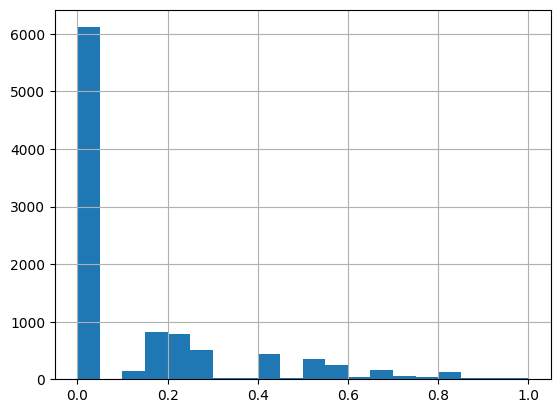

In [86]:
df["toxicity"].hist(bins=20)

We'll create 10 partitions; one with low toxicity levels, one with high toxicity levels, and the other 8 with a random mix of toxicity levels.

In [159]:
def assign_partition(toxicity):
    if toxicity < 0.1:
        return "9_low"
    elif toxicity > 0.9:
        return "9_high"
    else:
        i = np.random.choice([1, 2, 3, 4, 5, 6, 7, 8])
        return f"{i}_medium"

df["partition"] = df["toxicity"].apply(assign_partition)
df.head()

,Unnamed: 0,id,comment_text,split,created_date,publication_id,parent_id,article_id,rating,funny,...,identity_any,num_identities,more_than_one_identity,na_gender,na_orientation,na_religion,na_race,na_disability,partition,comment_embedding
0,315698,5041802,"Thank you Stephanie, great post. You should be...",train,2017-03-23 02:09:07.887924+00,55,NaN,320734,approved,0,...,0,0.0,False,1,1,1,1,1,9_low,"[0.031065112, 0.09312947, 0.03264505, -0.05552..."
1,205291,5924876,"Poor, poor us! We're so abused! Give it a brea...",train,2017-09-09 14:08:31.131728+00,54,5923381.0,375645,rejected,0,...,1,1.0,False,0,1,1,1,1,3_medium,"[0.05765602, 0.029650187, 0.05835239, 0.062011..."
2,98697,5926727,"Yeah, as we've gotten so used to with the Rock...",train,2017-09-09 20:35:55.150162+00,102,5924578.0,375714,approved,0,...,0,0.0,False,1,1,1,1,1,9_low,"[-0.084617205, 0.0032314418, -0.036742188, -0...."
3,42002,5785459,"If your actions thereby assist Sears' failure,...",test,2017-08-17 04:15:42.186750+00,54,5785299.0,367422,approved,0,...,0,0.0,False,1,1,1,1,1,9_low,"[-0.055978727, 0.0151619455, 0.055784963, -0.0..."
4,385519,5240478,"It is indeed a balancing act, but by supportin...",train,2017-05-10 22:34:47.727569+00,53,5238832.0,333501,approved,0,...,1,2.0,True,0,1,0,1,1,8_medium,"[0.027282983, -0.0051007248, 0.030560734, 0.00..."


## Create Embeddings

For the `comment_text` column, we create embeddings using the huggingface `sentence-transformers` library.

In [6]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
comments = df["comment_text"].tolist()
embeddings = model.encode(comments, show_progress_bar=True)

Batches: 100%|██████████| 313/313 [01:15<00:00,  4.16it/s]


In [7]:
df["comment_embedding"] = [e for e in embeddings]

## Create Partition Summaries

We use the `summarize` function to create partition summaries for each partition. We use the `comment_text` column as the embedding key, and the `comment_embedding` column as embedding value. We also pass in other columns that we want to compute statistics for.

In [160]:
columns = [
    "rating",
    "toxicity"
]
partition_key = "partition"
embedding_key = "comment_text"
embedding_value = "comment_embedding"


In [161]:
summaries = summarize(df, columns, partition_key=partition_key, embedding_column_map={embedding_key: embedding_value})
print(f"Computed summaries for {len(summaries)} partitions.")

Computed summaries for 10 partitions.


We can print out the summary of the first partition:

In [143]:
print(summaries[0])

Regular summary:
  partition    column  coverage      mean  num_unique_values  occurrence_ratio  p50       p95
0  1_medium    rating       1.0       NaN                2.0          0.883516  NaN       NaN
1  1_medium  toxicity       1.0  0.345642                NaN               NaN  0.3  0.707692
Embedding summary:
    partition                 column  coverage          mean           p50           p95
0    1_medium    comment_embedding_0       1.0  2.566922e-02  2.457224e-02  1.100073e-01
1    1_medium    comment_embedding_1       1.0  1.813742e-02  1.855958e-02  1.013335e-01
2    1_medium   comment_embedding_10       1.0  1.677387e-03  6.762206e-03  8.198688e-02
3    1_medium  comment_embedding_100       1.0 -3.462402e-02 -3.289469e-02  3.170577e-02
4    1_medium  comment_embedding_101       1.0  1.313250e-02  1.312971e-02  8.963184e-02
5    1_medium  comment_embedding_102       1.0 -4.987243e-03 -4.862877e-03  7.379767e-02
6    1_medium  comment_embedding_103       1.0 -1.457789e-0

## Compute Drift

For each partition after the first 5 partitions, we compute the drift between the partition and historical partitions.

In [162]:
partition_names = [s.partition for s in summaries]

In [194]:
drifted_partitions = {}

for i in range(len(summaries)-2, len(summaries)):
    print(f"Checking partition {partition_names[i]}...")
    drift_results = detect_drift(summaries[i], summaries[:i])    
    if drift_results.score_percentile > 0.85: # We use this instead of is_drifted since is_drifted's threshold is 95th percentile, and we want to be less strict since we only have 10 partitions
        print(f"Drift detected in partition {partition_names[i]}!")
        drifted_partitions[partition_names[i]] = drift_results

Checking partition 9_high...
Drift detected in partition 9_high!
Checking partition 9_low...
Drift detected in partition 9_low!


## Inspect Drift Results

For the high and low toxicity partitions, we can print out the top drifted columns and drift score.

In [195]:
def get_summary(partition_name):
    for summary in summaries:
        if summary.partition == partition_name:
            return summary
    return None


partition_name = list(drifted_partitions.keys())[0]
print(partition_name)
drift_results_high = drifted_partitions[partition_name]
print(drift_results_high)

9_high
Drift score: 76.0686 (100.00% percentile)
Top drifted columns:
                          statistic   z-score
column                                       
toxicity                        p50  2.666667
rating             occurrence_ratio -2.586768
comment_embedding              mean  1.793594


In [196]:
partition_name = list(drifted_partitions.keys())[1]
print(partition_name)
drift_results_low = drifted_partitions[partition_name]
print(drift_results_low)

9_low
Drift score: 50.6208 (88.89% percentile)
Top drifted columns:
                          statistic   z-score
column                                       
toxicity                        p95 -2.695175
comment_embedding              mean  1.243735
rating             occurrence_ratio  1.094245


### Look at Drifted Embeddings for High Toxicity Partition

In the drifted partition, we can identify the cluster of embeddings that diverged most from its values in historical partitions.

`drifted_examples` represents the examples in the drifted partition. `corresponding_examples` represents the examples in the historical partitions.

In [197]:
result = drift_results_high.drifted_examples("comment_text")
drifted_examples = result["drifted_examples"]
corresponding_examples = result["corresponding_examples"]

In [198]:
drifted_examples[embedding_key].to_list()

['Lord, what a tedious, tiresome, transparently deceptive and misleading troll you are.  Are you so delusional that you cannot see by the reactions of other posters that nobody is buying your repetitive and specious spins?  Obviously, Cassie (or whomever you are) your only recourse here is to go on the offensive and attack the reporters and the opposition with blatant lies and misleading out of context drive by smears.  You are certainly succeeding in being offensive, very offensive, but this is one pig that not even you can put lipstick on.   Give it rest.  Maybe run away for a week or so like Trudeau did.',
 "If you're saying that Trudeau is anti-Semitic, you're bonkers.",
 "John Gibbons is a terrible manager, will add to my already quite-lengthy list of head-scratchingly dumb decisions.  Friday's game, top of the 9th, 5-1 Min, runners on the corners, 1 out.  Gibbons draws the infield in, to cut off the run at the plate, rather than playing DP depth, which is a no-brainer in that sit

In [200]:
corresponding_examples[embedding_key].to_list()

['How about this: If the priest is a woman "it would be difficult to see in the minister the image of Christ. For Christ himself was and remains a man."  This says (1) the incarnation of Christ as a male is more significant than his incarnation as a human being; (2) that women are inferior to men, since they are not worthy of "imaging Christ"; (3) the faithful are too stupid to see Christ in a woman.\n\nNo, the reasons that women cannot be ordained is the hoary old "women are inferior to me". You traditionalists show your dishonesty in pretending it isn\'t, which is a major reason for rejecting your ideology.\n\n"All your objections to OS and subsequent documents are reduced to, \'women can\'t be ordained because the pope said so\', and you expect people to take that as Gospel just on your say-so. There is now no reason to investigate further because John Hobson has pronounced upon the matter."\n\nI spoke about ONE document, OS. I said NOTHING about subsequent documents. You didn\'t in

It looks like the religious comments have drifted to be more toxic!

We can do the same thing from the low toxicity partition. But the results don't make as much sense here.

In [204]:
result = drift_results_low.drifted_examples("comment_text")
drifted_examples = result["drifted_examples"]
corresponding_examples = result["corresponding_examples"]

In [205]:
drifted_examples[embedding_key].to_list()

['Did anybody notice?  If this is supposedly a driverless train, why does it need wipers on the windshield?',
 "Yes, and I'll bet that you can't cite the lawyer, the case number, or the final report number.  Right?",
 'Amen!  God Bless!',
 'It sounds like that may be my ex wife.',
 'Just gleaning off PERSONAL EXPERIENCE. As a foreigner when over there.\n\nBut what do I know?? ;-)',
 'Just a SA professional blogger paid to stir the pot.  "Allie" could be a 45 year old "Man" named "Dan".   Get it?  LOL.',
 "Some woman must have really done you wrong in the past, for you to be so obsessed with projecting your own perspective on every single news story about a woman allegedly being abused.\n\nWhat crimes were you falsely accused of??   It is so obvious that some woman must have really abused you very badly in the past, for you to be holding onto such an intense grudge that you must speak out whenever these kinds of news stories are printed.\n\nPlease stop projecting your unfortunate experi

In [206]:
corresponding_examples[embedding_key].to_list()

["Hmm.  So, shannonhall, are you saying that if a person doesn't like Canada's multiculturalism, doesn't like that muslim women have the right to wear hijabs or even niqabs, doesn't like that our constitution provides the right to protest and demonstrate, doesn't like Human Rights Tribunals . . . that they should move?  \n\nInteresting concept.",
 "The world has nothing to do with 'Obummers' CIA mercenaries,house of Saud terrorists,and shiny ponies flooding our country with Muslim extremists. Real Syrians stand up and fight for their country, like Canadians did in all their conflicts, and not sponge off the fake sincerity and 'generosity' of our local little potato red book waver!",
 "Fine, the White Nationalist's actions are disgusting. Angela, do you have any comment concerning the Antifists who attacked them? How about the police, who pushed the groups together rather than trying to separate them?\n\nAnd, by the way, until you get your Muslim terrorism problem addressed, maybe you s